# Case Study #3 : Gear-tooth Inspection
In industrial machine vision, how a watch gear could be inspected to check whether it had any missing or broken teeth. The inspection gear-tooth has maximum measurement of 7 mm and minimum defect size of 0.005 mm should be detected. Tolerance and margin will be fixed for 1 mm. The aspect ratio of the camera be 4:3. 1.Determine the camera resolution and FOV.
Camera should have enough resolution to
have at least 3 pixels for minimum defect size.
2.Find the location of missing or broken teeth
by using OpenCV.

In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [44]:
# Part 1: Camera Resolution and FOV Calculation
max_measurement = 7       # mm (gear diameter)
min_defect = 0.005        # mm (minimum defect size)
min_pixels = 3            # minimum pixels per defect
tolerance = 1             # mm (tolerance and margin)
aspect_ratio = (4, 3)

# FOV = max measurement + 2 * tolerance (margin on each side)
fov_h = max_measurement + 2 * tolerance  # horizontal FOV
fov_v = fov_h * (aspect_ratio[1] / aspect_ratio[0])  # vertical FOV

# Pixel resolution: need at least 3 pixels per minimum defect
pixel_size = min_defect / min_pixels  # mm per pixel

# Number of pixels
res_h = int(fov_h / pixel_size)
res_v = int(fov_v / pixel_size)

print("=" * 50)
print("Part 1: Camera Resolution and FOV")
print("=" * 50)
print(f"FOV (Horizontal): {fov_h} mm")
print(f"FOV (Vertical):   {fov_v} mm")
print(f"Pixel Size:       {pixel_size:.6f} mm/pixel")
print(f"Resolution:       {res_h} x {res_v} pixels")
print(f"Aspect Ratio:     {aspect_ratio[0]}:{aspect_ratio[1]}")
print("=" * 50)

Part 1: Camera Resolution and FOV
FOV (Horizontal): 9 mm
FOV (Vertical):   6.75 mm
Pixel Size:       0.001667 mm/pixel
Resolution:       5400 x 4049 pixels
Aspect Ratio:     4:3


In [47]:
from scipy.signal import find_peaks

def draw_triangle(img, center, tip_pt, base_len=10, width=8, color=(0, 255, 0)):
    """Draw a triangle marker pointing from center toward tip_pt."""
    tip_x, tip_y = tip_pt
    vec = np.array([tip_x - center[0], tip_y - center[1]], dtype=np.float32)
    norm = np.linalg.norm(vec)
    if norm == 0:
        return
    unit_vec = vec / norm
    perp_vec = np.array([-unit_vec[1], unit_vec[0]], dtype=np.float32)
    base_center = np.array([tip_x, tip_y]) - unit_vec * base_len
    pt1 = np.array([tip_x, tip_y], dtype=np.int32)
    pt2 = (base_center + perp_vec * (width / 2)).astype(np.int32)
    pt3 = (base_center - perp_vec * (width / 2)).astype(np.int32)
    pts = np.array([pt1, pt2, pt3], np.int32)
    cv2.polylines(img, [pts], isClosed=True, color=color, thickness=1, lineType=cv2.LINE_8)


def inspect_gear(cnt, display_img, label, mm_per_px=None):
    """Inspect a single gear contour for missing/broken teeth.
    
    Args:
        mm_per_px: mm per pixel scale from Part 1. If provided, results
                   include real-world measurements (diameter, tooth pitch).
    """
    img_h, img_w = display_img.shape[:2]

    if len(cnt) < 5:
        return {}

    # Fit ellipse to handle perspective distortion
    ellipse = cv2.fitEllipse(cnt)
    (xc, yc), (d1, d2), angle = ellipse
    center = (int(xc), int(yc))
    ref_r = max(d1, d2) / 2

    # Compute rotation and inverse rotation matrices
    M_rot = cv2.getRotationMatrix2D((xc, yc), angle, 1.0)
    M_inv_rot = cv2.getRotationMatrix2D((xc, yc), -angle, 1.0)
    scale_x = d2 / d1 if d1 != 0 else 1.0

    # Normalize contour points: rotate to align ellipse axes, then scale to circle
    norm_data = []
    for p in cnt:
        px, py = p[0]
        p_rot = np.dot(M_rot, [px, py, 1])
        nx = xc + (p_rot[0] - xc) * scale_x
        ny = p_rot[1]
        dist = np.sqrt((nx - xc)**2 + (ny - yc)**2)
        ang = np.degrees(np.arctan2(ny - yc, nx - xc))
        if ang < 0:
            ang += 360
        norm_data.append({'angle': ang, 'dist': dist, 'raw_pt': (px, py)})

    norm_data.sort(key=lambda x: x['angle'])
    dists = np.array([p['dist'] for p in norm_data])

    # Detect tooth tip peaks in the radial profile
    peaks, _ = find_peaks(dists, distance=10, height=np.mean(dists))
    actual_peaks = [norm_data[p] for p in peaks]
    actual_angles = np.array([p['angle'] for p in actual_peaks])

    if len(actual_angles) < 2:
        return {}

    # Estimate expected tooth count from median angular pitch
    diffs = np.diff(actual_angles)
    wrap_diff = (360 - actual_angles[-1]) + actual_angles[0]
    median_pitch = np.median(np.append(diffs, wrap_diff))
    expected_count = int(round(360 / median_pitch))

    # Pattern auto-alignment: find the angular offset that best matches detected teeth
    best_offset = 0
    min_error = float('inf')
    for offset in np.linspace(0, median_pitch, 20):
        total_err = 0
        for j in range(expected_count):
            ideal_a = (offset + j * median_pitch) % 360
            angle_diffs = np.abs(actual_angles - ideal_a)
            angle_diffs = np.minimum(angle_diffs, 360 - angle_diffs)
            total_err += np.min(angle_diffs)
        if total_err < min_error:
            min_error = total_err
            best_offset = offset

    # Compare each ideal tooth position against detected peaks
    missing_count = 0
    cv2.circle(display_img, center, 2, (0, 0, 255), -1, lineType=cv2.LINE_8)

    tolerance = median_pitch * 0.45
    for j in range(expected_count):
        ideal_a = (best_offset + j * median_pitch) % 360

        # Find closest detected tooth
        best_match = None
        min_diff = tolerance
        for pk in actual_peaks:
            diff = min(abs(pk['angle'] - ideal_a), 360 - abs(pk['angle'] - ideal_a))
            if diff < min_diff:
                min_diff = diff
                best_match = pk

        if best_match:
            draw_triangle(display_img, center, best_match['raw_pt'], color=(0, 255, 0))
        else:
            missing_count += 1
            nx = xc + ref_r * np.cos(np.radians(ideal_a))
            ny = yc + ref_r * np.sin(np.radians(ideal_a))
            target_pt = np.dot(M_inv_rot, [xc + (nx - xc) / scale_x, ny, 1])
            target_coord = (int(target_pt[0]), int(target_pt[1]))
            draw_triangle(display_img, center, target_coord, color=(0, 0, 255))

            # Draw angle label near the missing tooth
            angle_text = f"{ideal_a:.0f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.35
            (tw, th), _ = cv2.getTextSize(angle_text, font, font_scale, 1)

            text_r = ref_r + 28
            t_raw = np.dot(M_inv_rot, [xc + (xc + text_r * np.cos(np.radians(ideal_a)) - xc) / scale_x,
                                        yc + text_r * np.sin(np.radians(ideal_a)), 1])
            tx, ty = int(t_raw[0]), int(t_raw[1])

            if tx < 5 or tx + tw > img_w - 5 or ty - th < 5 or ty > img_h - 5:
                t_raw = np.dot(M_inv_rot, [xc + (xc + (ref_r - 35) * np.cos(np.radians(ideal_a)) - xc) / scale_x,
                                            yc + (ref_r - 35) * np.sin(np.radians(ideal_a)), 1])
                tx, ty = int(t_raw[0]), int(t_raw[1])

            cv2.rectangle(display_img, (tx - 1, ty - th - 1), (tx + tw + 1, ty + 1), (0, 0, 0), -1)
            cv2.putText(display_img, angle_text, (tx, ty), font, font_scale, (0, 255, 255), 1, lineType=cv2.LINE_8)

    # Build result dict with pixel and real-world measurements
    result = {
        'expected': expected_count,
        'detected': len(peaks),
        'missing': missing_count,
        'radius_px': ref_r,
        'pitch_deg': median_pitch,
    }

    # Convert to mm using Part 1 scale if provided
    if mm_per_px is not None:
        result['diameter_mm'] = ref_r * 2 * mm_per_px
        tooth_arc_px = ref_r * np.radians(median_pitch)
        result['tooth_pitch_mm'] = tooth_arc_px * mm_per_px

    return result


def draw_top_bar(display_img, results):
    """Draw a single-line status bar at the top of the image."""
    img_h, img_w = display_img.shape[:2]
    bar_h = 20

    overlay = display_img[0:bar_h, 0:img_w].copy()
    dark = np.zeros_like(overlay)
    display_img[0:bar_h, 0:img_w] = cv2.addWeighted(overlay, 0.3, dark, 0.7, 0)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fs = 0.35
    x = 8
    y = 14

    for i, (label, info) in enumerate(results):
        m_color = (0, 255, 0) if info['missing'] == 0 else (0, 100, 255)

        if i > 0:
            cv2.putText(display_img, "|", (x, y), font, fs, (100, 100, 100), 1)
            x += 14

        txt = f"Gear {label}: {info['expected']} exp / "
        cv2.putText(display_img, txt, (x, y), font, fs, (220, 220, 220), 1)
        x += cv2.getTextSize(txt, font, fs, 1)[0][0]

        miss_txt = f"{info['missing']} miss"
        cv2.putText(display_img, miss_txt, (x, y), font, fs, m_color, 1)
        x += cv2.getTextSize(miss_txt, font, fs, 1)[0][0] + 10

print("Functions defined successfully.")

Functions defined successfully.


Image size: 438 x 262 px
Scale: 0.0205 mm/pixel (from Part 1 FOV = 9 mm)

GEAR TOOTH INSPECTION RESULTS

Gear A:
  Expected teeth:  63
  Detected teeth:  62
  Missing teeth:   1
  Radius:          92.8 px
  Diameter:        3.81 mm
  Tooth pitch:     5.68° (0.1891 mm)

Gear B:
  Expected teeth:  63
  Detected teeth:  62
  Missing teeth:   1
  Radius:          91.3 px
  Diameter:        3.75 mm
  Tooth pitch:     5.69° (0.1863 mm)


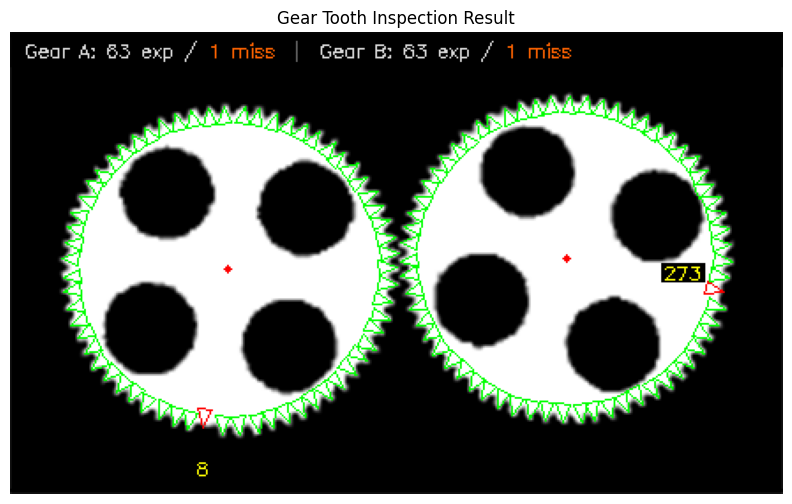


Legend:
  GREEN triangle = Tooth present
  RED triangle   = Missing tooth (with angle label)
  Top bar        = Summary per gear


In [48]:
# Step 2: Load image, find gear contours, and run inspection
img = cv2.imread('case3.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Compute mm/pixel scale using Part 1 FOV and actual image width
img_h, img_w = img.shape[:2]
mm_per_px = fov_h / img_w  # maps image pixels to real-world mm

print(f"Image size: {img_w} x {img_h} px")
print(f"Scale: {mm_per_px:.4f} mm/pixel (from Part 1 FOV = {fov_h} mm)")

# Find external contours and keep the two largest (the gears)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
gear_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
gear_contours = sorted(gear_contours, key=lambda c: cv2.minEnclosingCircle(c)[0][0])

display_img = img.copy()

print("\n" + "=" * 50)
print("GEAR TOOTH INSPECTION RESULTS")
print("=" * 50)

labels = ["A", "B"]
bar_results = []

for i, cnt in enumerate(gear_contours):
    info = inspect_gear(cnt, display_img, labels[i], mm_per_px=mm_per_px)
    bar_results.append((labels[i], info))

    print(f"\nGear {labels[i]}:")
    print(f"  Expected teeth:  {info['expected']}")
    print(f"  Detected teeth:  {info['detected']}")
    print(f"  Missing teeth:   {info['missing']}")
    print(f"  Radius:          {info['radius_px']:.1f} px")
    print(f"  Diameter:        {info['diameter_mm']:.2f} mm")
    print(f"  Tooth pitch:     {info['pitch_deg']:.2f}° ({info['tooth_pitch_mm']:.4f} mm)")

# Draw status bar at the top
draw_top_bar(display_img, bar_results)

# Display result
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
plt.title('Gear Tooth Inspection Result')
plt.axis('off')
plt.show()

print("\nLegend:")
print("  GREEN triangle = Tooth present")
print("  RED triangle   = Missing tooth (with angle label)")
print("  Top bar        = Summary per gear")